In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt

sns.set_style('white')

In [2]:
DATA = '../data/'

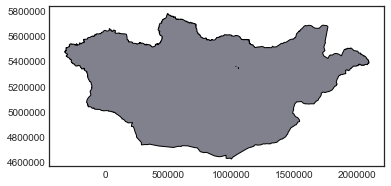

In [3]:
mongolia_map = gpd.read_file(DATA+'GIS/mongolia/mongolia_alagac_utm.shp')
mongolia_map.plot()

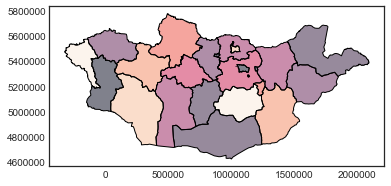

In [4]:
aimag_map = gpd.read_file(DATA+'GIS/aimag_boundaries/aimags_alagac_utm.shp').drop('NAME_L1', axis=1)
aimag_map.plot()

In [5]:
aimag_lookup = {'UB':'Ulaanbaatar',
            'DO':'Dornod',
            'SB':"Su'xbaatar", 
            'KhE':'Xentii',
            'TU':"To'v",
            'GS':"Govisu'mber", 
            'BG':'Dornogovi',
            'DA':'Darxan-Uul',
            'DU':'Dundgovi',
            'OR':'Orxon',
            'UV':"O'vorxangai", 
            'BU':'Bulgan',
            'BKh':'Bayanxongor',
            'AR':'Arxangai',
            'KhU':"Xo'vsgol",
            'ZA':'Zavxan',
            'GA':'Govi-Altai',
            'Bay':"Bayan-O'lgii", 
            'KhO':'Xovd',
            'UG':"O'mnogovi", 
            'UVs':'Uvs',
            'SE':'Selenge'}

In [6]:
aimag_map['Province'] = aimag_map.NAME.replace({aimag_lookup[code]:code for code in aimag_lookup})

Import line list

In [7]:
line_list = pd.read_csv(DATA+'clean/line_list.csv', parse_dates=['date_onset', 'dob', 'date_lab'])

In [8]:
lab_samples = line_list.dropna(subset=['date_lab']).copy()
lab_samples.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
8,20835.0,2015-11-25,UB,2015-09-01,0.238193,1.0,1.0,1.0,2015-12-01,0.0,True,11.0,2015.0
9,21053.0,2015-12-02,UB,2014-11-19,1.062286,0.0,1.0,1.0,2015-12-14,0.0,False,12.0,2015.0


In [9]:
pd.crosstab(lab_samples.confirmed, lab_samples.labconfirmed)

labconfirmed,0.0,1.0
confirmed,,
0.0,1218,0
1.0,1855,4015


In [10]:
aimag_map.head()

,AREA_M2,ID,LENGTH_M,NAME,OBJECTID,PARENT_ID,SHAPE_AREA,SHAPE_LEN,TYPE,UNIT_STATU,geometry,Province
0,4.735383e+09,11,4.786412e+05,Ulaanbaatar,2,1,4736.028353,5.405426,2,1,(POLYGON ((1064208.858495513 5370725.455944032...,UB
1,1.235185e+11,21,2.208690e+06,Dornod,3,1,123527.196907,25.333832,2,1,"POLYGON ((1540617.076159357 5638446.384644163,...",DO
2,8.235105e+10,22,1.323859e+06,Su'xbaatar,4,1,82323.874121,14.860285,2,1,"POLYGON ((1526003.850553003 5389374.5959672, 1...",SB
3,8.069372e+10,23,1.472892e+06,Xentii,5,1,80745.839694,16.285330,2,1,"POLYGON ((1448514.971882628 5552536.507390657,...",KhE
4,7.396939e+10,41,2.046344e+06,To'v,6,1,73988.555729,23.471340,2,1,"POLYGON ((1193224.564212453 5488464.533822741,...",TU


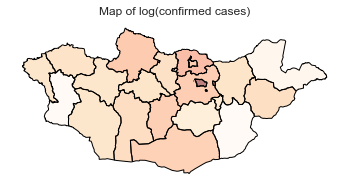

In [11]:
ax = (aimag_map.join(lab_samples.assign(NAME=lab_samples.provincecity.replace(aimag_lookup))
                 .groupby('NAME')
                 .labconfirmed.sum().apply(np.log), on='NAME')
             .plot(column='labconfirmed', cmap='OrRd'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_title('Map of log(confirmed cases)');

In [12]:
lab_samples['onset_to_lab'] = (lab_samples.date_lab - lab_samples.date_onset).dt.days

In [13]:
(lab_samples.onset_to_lab<0).sum()

33

In [14]:
lab_samples.loc[lab_samples.onset_to_lab<0, 'onset_to_lab'] = np.nan

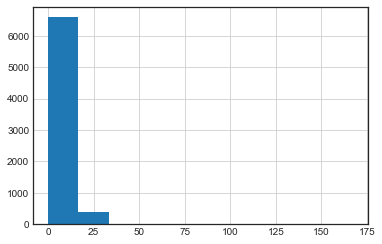

In [15]:
lab_samples.onset_to_lab.hist()

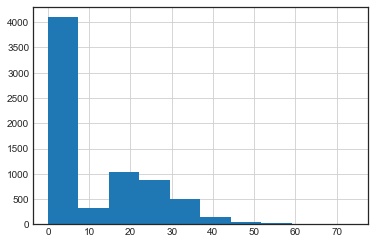

In [16]:
lab_samples.age_years.hist()

Extract clinic-confirmed cases

In [17]:
clinic_confirmed = lab_samples.query('confirmed==1')

In [18]:
clinic_confirmed.isnull().sum()

id                 0
date_onset        29
provincecity       2
dob               22
age_years         24
died               0
confirmed          0
labconfirmed       0
date_lab           0
vaccine_ever    1797
male               0
month_onset       29
year_onset        29
onset_to_lab      56
dtype: int64

### Reporting lag model

In [21]:
from pymc3 import sample, Model, invlogit, Minibatch, fit, generator, sample_ppc
from pymc3 import Deterministic, SVGD, GaussianRandomWalk
from pymc3.gp import cov
from pymc3 import MvNormal, Normal, Bernoulli, Gamma, HalfCauchy, Uniform, Flat
from pymc3 import traceplot, forestplot, summary, generator, energyplot
from pymc3.math import invprobit

import theano.tensor as tt
from theano import shared

In [22]:
def interpolate(x0, y0, x):
    
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [23]:
lag, confirmed = clinic_confirmed.dropna(subset=['onset_to_lab'])[['onset_to_lab', 'labconfirmed']].values.T

In [24]:
n_knots = 10
knots = np.linspace(lag.min(), lag.max(), n_knots)

with Model() as lag_model:
    
    σ = HalfCauchy('σ', 1)

    y = GaussianRandomWalk('y', sd=σ, shape=n_knots)

    α = interpolate(knots, y, lag)
    
    π = invlogit(α)
        
    confirmation = Bernoulli('confirmation', π, observed=confirmed)

In [25]:
with lag_model:
#     lag_trace = sample(2000, burn=1000, n_init=10000)
    lag_trace = fit(method='fullrank_advi', n=50000).sample(1000)

Average Loss = 3,617.3: 100%|██████████| 50000/50000 [01:27<00:00, 572.20it/s]
Finished [100%]: Average Loss = 3,617.3


In [26]:
energyplot(lag_trace)

There is no energy information in the passed trace.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125ee2d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13035c9e8>]], dtype=object)

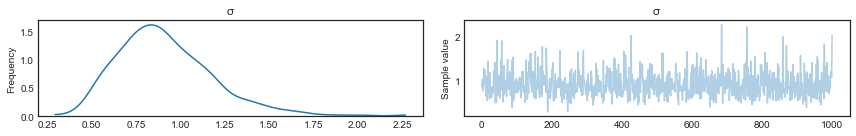

In [27]:
traceplot(lag_trace, varnames=['σ'])

In [28]:
expit = lambda x: 1/(1 + np.exp(-x))

In [29]:
lag_data = pd.DataFrame({'lag': lag,
                        'obs': confirmed})

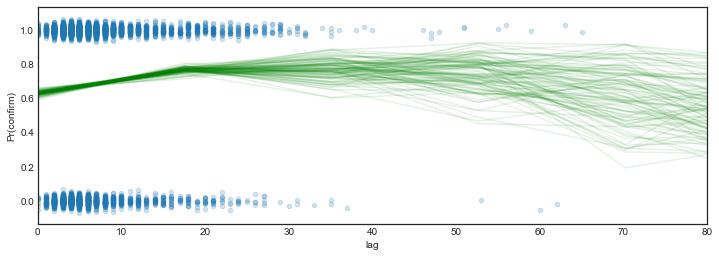

In [30]:
ax = (lag_data.assign(obsj=lag_data.obs+0.02*np.random.randn(len(lag_data)))
              .plot.scatter(x='lag', y='obsj', alpha=0.2, figsize=(12,4)))
plt.plot(knots, expit(lag_trace['y', -100:]).T, 'g-', alpha=0.1)
ax.set_xlim(0,80)
ax.set_ylabel('Pr(confirm)');

### Age model

In [31]:
confirmed, age = clinic_confirmed.dropna(subset=['age_years'])[['labconfirmed', 'age_years']].values.T

In [32]:
n_knots = 20
knots = np.linspace(age.min(), age.max(), n_knots)

with Model() as age_model:
    
    σ = HalfCauchy('σ', 1)

    y = GaussianRandomWalk('y', sd=σ, shape=n_knots)

    α = interpolate(knots, y, age)
    
    π = invlogit(α)
        
    confirmation = Bernoulli('confirmation', π, observed=confirmed)

In [33]:
with age_model:
    trace_age = fit(method='fullrank_advi', n=50000).sample(1000)
    #sample(2000, n_init=50000, tune=1000, njobs=2)

Average Loss = 3,525.3: 100%|██████████| 50000/50000 [01:41<00:00, 490.23it/s]
Finished [100%]: Average Loss = 3,525.3


Convergence diagnostic

In [34]:
energyplot(trace_age)

There is no energy information in the passed trace.


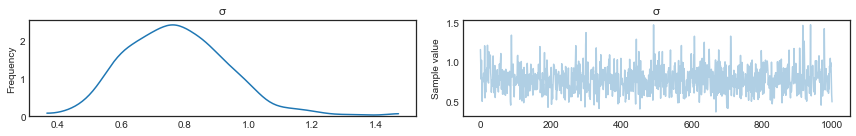

In [35]:
traceplot(trace_age, varnames=['σ']);

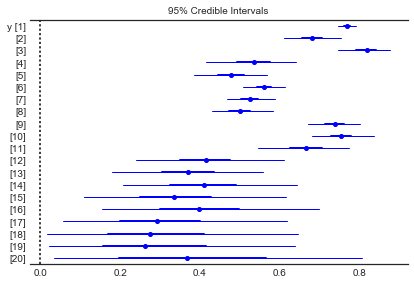

In [36]:
forestplot(trace_age, varnames=['y'], transform=expit)

In [37]:
predictions = pd.DataFrame({'age': age,
                            'obs': confirmed})

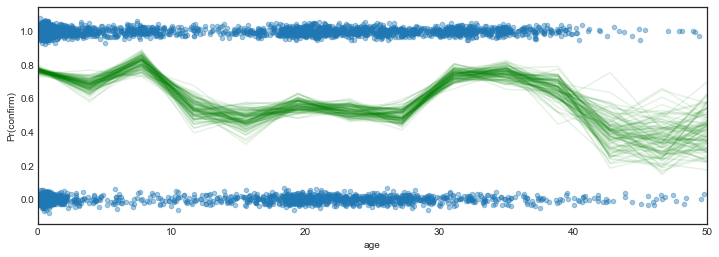

In [38]:
ax = (predictions.assign(obsj=predictions.obs+0.02*np.random.randn(len(predictions)))
              .plot.scatter(x='age', y='obsj', alpha=0.4, figsize=(12,4)))
plt.plot(knots, expit(trace_age['y', -100:]).T, 'g-', alpha=0.1)
ax.set_xlim(0,50)
ax.set_ylabel('Pr(confirm)');

## Combined model

In [53]:
def interpolate2d(x, y, Z, points, mode='linear', bounds_error=False):
    """Fundamental 2D interpolation routine
    Input
        x: 1D array of x-coordinates of the mesh on which to interpolate
        y: 1D array of y-coordinates of the mesh on which to interpolate
        Z: 2D array of values for each x, y pair
        points: Nx2 array of coordinates where interpolated values are sought
        mode: Determines the interpolation order. Options are
              'constant' - piecewise constant nearest neighbour interpolation
              'linear' - bilinear interpolation using the four
                         nearest neighbours (default)
        bounds_error: Boolean flag. If True (default) an exception will
                      be raised when interpolated values are requested
                      outside the domain of the input data. If False, nan
                      is returned for those values
    Output
        1D array with same length as points with interpolated values
    Notes
        Input coordinates x and y are assumed to be monotonically increasing,
        but need not be equidistantly spaced.
        Z is assumed to have dimension M x N, where M = len(x) and N = len(y).
        In other words it is assumed that the x values follow the first
        (vertical) axis downwards and y values the second (horizontal) axis
        from left to right.
        If this routine is to be used for interpolation of raster grids where
        data is typically organised with longitudes (x) going from left to
        right and latitudes (y) from left to right then user
        interpolate_raster in this module
    """

    # Input checks
    x, y, Z, xi, eta = check_inputs(x, y, Z, points, mode, bounds_error)

    # Identify elements that are outside interpolation domain or NaN
    outside = (xi < x[0]) + (eta < y[0]) + (xi > x[-1]) + (eta > y[-1])
    outside += np.isnan(xi) + np.isnan(eta)

    inside = -outside
    xi = xi[inside]
    eta = eta[inside]

    # Find upper neighbours for each interpolation point
    idx = np.searchsorted(x, xi, side='left')
    idy = np.searchsorted(y, eta, side='left')

    # Get the four neighbours for each interpolation point
    x0 = x[idx - 1]
    x1 = x[idx]
    y0 = y[idy - 1]
    y1 = y[idy]

    z00 = Z[idx - 1, idy - 1]
    z01 = Z[idx - 1, idy]
    z10 = Z[idx, idy - 1]
    z11 = Z[idx, idy]

    # Coefficients for weighting between lower and upper bounds
    oldset = np.seterr(invalid='ignore')  # Suppress warnings
    alpha = (xi - x0) / (x1 - x0)
    beta = (eta - y0) / (y1 - y0)
    np.seterr(**oldset)  # Restore

    if mode == 'linear':
        # Bilinear interpolation formula
        dx = z10 - z00
        dy = z01 - z00
        z = z00 + alpha * dx + beta * dy + alpha * beta * (z11 - dx - dy - z00)
    else:
        # Piecewise constant (as verified in input_check)

        # Set up masks for the quadrants
        left = alpha < 0.5
        right = -left
        lower = beta < 0.5
        upper = -lower

        lower_left = lower * left
        lower_right = lower * right
        upper_left = upper * left

        # Initialise result array with all elements set to upper right
        z = z11

        # Then set the other quadrants
        z[lower_left] = z00[lower_left]
        z[lower_right] = z10[lower_right]
        z[upper_left] = z01[upper_left]


    # Populate result with interpolated values for points inside domain
    # and NaN for values outside
    r = tt.zeros(len(points))
    r = tt.set_subtensor(r[inside], z)
    r = tt.set_subtensor(r[outside], np.nan)

    return r

def check_inputs(x, y, Z, points, mode, bounds_error):
    """Check inputs for interpolate2d function
    """

    m, n = Z.shape

    Nx = len(x)
    Ny = len(y)


    # Get interpolation points
    points = np.array(points)
    xi = points[:, 0]
    eta = points[:, 1]

    return x, y, Z, xi, eta


In [54]:
confirmed, age, lag = clinic_confirmed.dropna(subset=['age_years', 'onset_to_lab'])[['labconfirmed', 'age_years', 'onset_to_lab']].values.T

In [55]:
n_knots = 20
age_knots = np.linspace(age.min(), age.max(), n_knots)
lag_knots = np.linspace(lag.min(), lag.max(), n_knots)
# age_knots, lag_knots = np.meshgrid(age_knots, lag_knots)

with Model() as combined_model:
    
    σ = HalfCauchy('σ', 1)

    y = GaussianRandomWalk('y', sd=σ, shape=(n_knots, n_knots))
    α = interpolate2d(age_knots, lag_knots, y, np.array(list(zip(age, lag))))
    
    π = invlogit(α)
        
    confirmation = Bernoulli('confirmation', π, observed=confirmed)

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


TypeError: TensorType does not support boolean mask for indexing such as tensor[x==0]. Instead you can use non_zeros() such as tensor[(x == 0).nonzeros()]. 

In [ ]:
with combined_model:
    trace_age = fit(method='fullrank_advi', n=50000).sample(1000)
    #sample(2000, n_init=50000, tune=1000, njobs=2)